<h1>Titaniс Kaggle competition</h1>

<h2>1. Handling missing data and feature engeneering</h2>

This is binary classification problem, supervised machine learning.

In our `train.csv` dataset we have `Survived` column. It will be our target. There are some problems that need to be addresed before we start training various models. Let's take a look on the original dataset: 


In [352]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

train_path = "train.csv"

titanic_df = pd.read_csv(train_path)
titles = {
    'Mr.': 'Mr',
    "Mrs.": 'Mrs',
    "Miss.": 'Miss',
    "Master.": 'Master',
    'Lady': 'Lady',
    'Sir.': 'Sir',
    'Count': 'Count',
    'Major': 'Major',
}
titanic_df['title'] = 0
for i, name in enumerate(titanic_df['Name']):
    for key in titles:
        if key in name:
            titanic_df['title'].iloc[i] = titles[key]
titanic_df.loc[titanic_df['title'] == 'Major'].head()

/tmp/ipykernel_6220/2448969598.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['title'].iloc[i] = titles[key]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.50,C104,S,Major
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.55,B38,S,Major


First of all, we should handle missing data.

I will start with the `Age`.

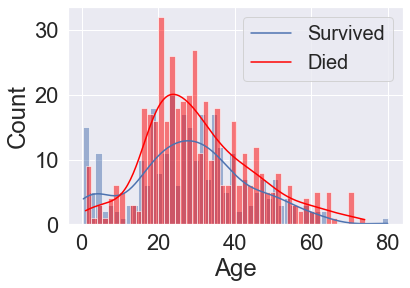

Missing age ratio among survived: 24.03
Missing age ratio among deceased: 23.65


In [353]:
sns.set(font_scale=2)
sns.histplot(data=titanic_df.loc[titanic_df['Survived'] == 1, 'Age'],\
             kde=True, legend=True, bins=50)
sns.histplot(data=titanic_df.loc[titanic_df['Survived'] == 0, 'Age'],\
             kde=True, color="red", bins=50)
plt.legend(labels=['Survived', 'Died'], prop={"size": 20})
plt.show()

print(f"Missing age ratio among \
survived: {titanic_df.loc[titanic_df['Survived'] == 1, 'Age'].sum()/len(titanic_df.loc[titanic_df['Survived'] == 1, 'Age']):.2f}")
print(f"Missing age ratio among \
deceased: {titanic_df.loc[titanic_df['Survived'] == 0, 'Age'].sum()/len(titanic_df.loc[titanic_df['Survived'] == 0, 'Age']):.2f}")

If we fill our missing data with mean or median value, we will destroy this relation. Looks like, if we have a person with NaN in "Age" column, his odds to survive might be lower.

The second observation is: minors have better chances to survive, than the adults. Therefore I will divide Age col in three classes: Minor, Adult and Missing.




In [354]:
minor = titanic_df['Age'] < 11
adult = titanic_df['Age'] >= 11
titanic_df.loc[minor, 'Age'] = 'minor'
titanic_df.loc[adult, 'Age'] = 'adult'
titanic_df['Age'].fillna('missing', inplace=True)

What about `Embarked`?

I am gonna fill missing data with the most popular port (Southampton). After that I will examine the `Cabin` data.

In [355]:
print(f"People embarked at \
Southampton: {titanic_df.loc[titanic_df['Embarked'] == 'S', 'Embarked'].count()}")
print(f"People embarked at \
Cherbourg: {titanic_df.loc[titanic_df['Embarked'] == 'C', 'Embarked'].count()}")
print(f"People embarked at \
Queenstown: {titanic_df.loc[titanic_df['Embarked'] == 'Q', 'Embarked'].count()}")
titanic_df["Embarked"].fillna('S', inplace=True)
print(f"{100 * titanic_df['Cabin'].isnull().sum()/len(titanic_df['Cabin']):.0f}% \
of the \"Cabin\" data is missing.")
print(f"We don't know the cabin number of \
{titanic_df.loc[titanic_df['Survived'] == 1, 'Cabin'].isnull().sum()/len(titanic_df.loc[titanic_df['Survived'] == 1, 'Cabin']):.2f}% of survived passengers.")
print(f"We don't know cabin number of \
{titanic_df.loc[titanic_df['Survived'] == 0, 'Cabin'].isnull().sum()/len(titanic_df.loc[titanic_df['Survived'] == 0, 'Cabin']):.2f}% of deceased passengers.")

People embarked at Southampton: 644
People embarked at Cherbourg: 168
People embarked at Queenstown: 77
77% of the "Cabin" data is missing.
We don't know the cabin number of 0.60% of survived passengers.
We don't know cabin number of 0.88% of deceased passengers.


So... `Cabin`. Looks like the vast majority of the data is missing and there is no significant difference between survived and deceased passengers.

I am not gonna use `Cabin`, `Ticket` and `Name` columns.

In [356]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'title']
# features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
scaler = MinMaxScaler()

X = titanic_df[features].copy()
y = titanic_df['Survived'].copy()
y.columns = ['Survived']
X = pd.get_dummies(X, prefix=['Pclass', 'Sex', 'Embarked', 'Age', 'title'],\
                   columns=['Pclass', 'Sex', 'Embarked', 'Age', 'title'])
X.head(3)
X[["Fare"]] = scaler.fit_transform(X[["Fare"]])

`Survived` column mean value is less than 0.5. It means, there are more dead people in our dataset, than survived. We have to pay attention to the fact during our train-test splitting and use cross-validation.

I will start with linear_model library.

In [357]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve

train_X, test_X, train_y, test_y =\
train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
model = SGDClassifier(random_state=1)
grid = {'alpha': [1e-7, 1e-6, 1e-5],
    'penalty': ['l2']}

gs = GridSearchCV(model, grid, scoring="f1", n_jobs=-1, cv=10,
                     return_train_score=True)

gs.fit(train_X, train_y)
predictions = gs.predict(test_X)

print(f"gridsearch best_score = {gs.best_score_:0.3f}")
print(f"gridsearch best parameters = {gs.best_params_}")
print(classification_report(test_y.values, predictions))


gridsearch best_score = 0.646
gridsearch best parameters = {'alpha': 1e-06, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       110
           1       0.72      0.80      0.76        69

    accuracy                           0.80       179
   macro avg       0.79      0.80      0.80       179
weighted avg       0.81      0.80      0.81       179



In [385]:
from sklearn.ensemble import RandomForestClassifier

dt_model = RandomForestClassifier(random_state=1)
grid = {
    'max_leaf_nodes': [18, 19, 20],
       }
gs = GridSearchCV(dt_model, grid, scoring="f1", n_jobs=-1, cv=10,
                     return_train_score=True)

gs.fit(train_X, train_y)
predictions = gs.predict(test_X)

print(f"gridsearch best_score = {gs.best_score_:0.3f}")
print(f"gridsearch best parameters = {gs.best_params_}")
print(classification_report(test_y.values, predictions))

gridsearch best_score = 0.731
gridsearch best parameters = {'max_leaf_nodes': 19}
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       110
           1       0.86      0.74      0.80        69

    accuracy                           0.85       179
   macro avg       0.86      0.83      0.84       179
weighted avg       0.86      0.85      0.85       179



<h2>2. RandomForest model</h2>

In [369]:
rf_model = RandomForestClassifier(max_leaf_nodes=15)
rf_model.fit(X, y)

test_path = "test.csv"
test_df = pd.read_csv(test_path)

test_df['Fare'].fillna(14.45, inplace=True)

minor = test_df['Age'] < 10
adult = test_df['Age'] >= 10
test_df.loc[minor, 'Age'] = 'minor'
test_df.loc[adult, 'Age'] = 'adult'
test_df['Age'].fillna('missing', inplace=True)

test_df['title'] = 0
for i, name in enumerate(test_df['Name']):
    for key in titles:
        if key in name:
            test_df['title'].iloc[i] = titles[key]

t_X = test_df[features]
t_X = pd.get_dummies(t_X, prefix=['Pclass', 'Sex', 'Embarked', 'Age', 'title'],\
                     columns=['Pclass', 'Sex', 'Embarked', 'Age', 'title'])
t_X[['Fare']] = scaler.fit_transform(t_X[['Fare']])
t_X_new = pd.DataFrame()
for name in X.columns:
    if name in t_X.columns:
        t_X_new[name] = t_X[name]
    else:
        t_X_new[name] = 0

/tmp/ipykernel_6220/3598493761.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['title'].iloc[i] = titles[key]


In [370]:
t_predictions = rf_model.predict(t_X_new)

In [371]:
submission = pd.DataFrame()
submission['PassengerId'] = test_df['PassengerId']
submission['Survived'] = t_predictions
submission.to_csv("randomforest_model_with_titles_submission.csv", index=False)

<h2>3. XGBoost time</h2>

In [372]:
import xgboost as xgb

train_X, test_X, train_y, test_y =\
train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

xg_model = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_model.fit(train_X, train_y)
xg_predictions = xg_model.predict(test_X)
print(classification_report(test_y, xg_predictions))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       110
           1       0.75      0.74      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



Cross-validation is necessary.

In [381]:
grid = {"objective":["reg:logistic"],'colsample_bytree': [0.2],
          'learning_rate': [0.3],
          'max_depth': [2],
         'n_estimators': [60],
       }

xgb_gs = GridSearchCV(xg_model, grid, scoring="f1", n_jobs=-1, cv=10, return_train_score=True)

xgb_gs.fit(train_X, train_y)
xgb_cv_predictions = xgb_gs.predict(test_X)

print(f"gridsearch best_score = {xgb_gs.best_score_:0.3f}")
print(f"gridsearch best parameters = {xgb_gs.best_params_}")
print(classification_report(test_y, xgb_cv_predictions))

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resource

[18:54:05] WARNING: ../src/learner.cc:627: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


gridsearch best_score = 0.716
gridsearch best parameters = {'colsample_bytree': 0.2, 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 60, 'objective': 'reg:logistic', 'sample_weight': 0.2}
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       110
           1       0.77      0.72      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



In [375]:
f_xgb = xgb.XGBClassifier(objective="reg:logistic",\
                          colsample_bytree=0.2, learning_rate = 0.3,\
                          max_depth=2, n_estimators = 60)
f_xgb.fit(X, y)
t_predictions = f_xgb.predict(t_X_new)

In [376]:
submission = pd.DataFrame()
submission['PassengerId'] = test_df['PassengerId']
submission['Survived'] = t_predictions
submission.to_csv("xgboost_submission.csv", index=False)

<h2>3. Stacking classifiers </h2>

In [379]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

estimators_list = [
    ('sgdc', SGDClassifier(alpha=4e-9)),
    ('rf', rf_model),
    ('xgb', f_xgb),
]

clf = StackingClassifier(estimators=estimators_list, final_estimator=LogisticRegression())
clf.fit(train_X, train_y)

clf_pred = clf.predict(test_X)
print(classification_report(test_y, clf_pred))


              precision    recall  f1-score   support

           0       0.86      0.94      0.90       110
           1       0.88      0.75      0.81        69

    accuracy                           0.87       179
   macro avg       0.87      0.84      0.85       179
weighted avg       0.87      0.87      0.86       179



In [380]:
clf.fit(X, y)
clf_pred = clf.predict(t_X_new)
submission = pd.DataFrame()
submission['PassengerId'] = test_df['PassengerId']
submission['Survived'] = clf_pred
submission.to_csv("stacking_submission.csv", index=False)